# Adaptive Cruise Controller (ACC)


The Adaptive Cruise Control (ACC) benchmark is a system that tracks a set
velocity and maintains a safe distance from a lead vehicle by adjusting
the longitudinal acceleration of an ego vehicle.
The neural network computes optimal control actions while satisfying safe
distance, velocity, and acceleration constraints.

## Model

For this case study, the ego car is set to travel at a set speed $v_{set} = 30$
and maintains a safe distance $D_{safe}$ from the lead car.  The car’s dynamics
are described as follows:

$$
\left\{ \begin{array}{lcl}
\dot{x}_{lead}(t) &=& v_{lead}(t) \\
\dot{v}_{lead}(t) &=& \gamma_{lead}(t) \\
\dot{\gamma}_{lead}(t) &=& -2\gamma_{lead}(t) + 2a_{lead}(t) - uv_{lead}^2(t)  \\
\dot{x}_{ego}(t) &=& v_{ego}(t) \\
\dot{v}_{ego}(t) &=& \gamma_{ego}(t) \\
\dot{\gamma}_{ego}(t) &=& -2\gamma_{ego}(t) + 2a_{ego}(t) - uv_{ego}^2(t)
\end{array} \right.
$$
where ``x_i`` is the position, ``v_i`` is the velocity, ``γ_i`` is the
acceleration of the car, ``a_i`` is the acceleration control input applied
to the car, and ``u = 0.0001`` is the friction parameter, where
``i ∈ {ego, lead}``. For this benchmark we are given four neural network
controllers with 3, 5, 7, and 10 hidden layers of 20 neurons each, but only evaluate
the controller with 5 hidden layers. All of them have the same number of inputs
``(v_{set}, T_{gap}, v_{ego}, D_{rel}, v_{rel})`` and one output (``a_{ego}``).

In [1]:
using Revise

In [2]:
using NeuralNetworkAnalysis, MAT
using NeuralNetworkAnalysis: NoNormalization, FunctionPreprocessing

const u = 0.0001  # friction parameter
const a_lead = -2.0  # acceleration control input applied to the lead vehicle
const v_set = 30.0  # ego car's set speed

@taylorize function ACC!(dx, x, p, t)
    v_lead = x[2]  # lead car velocity
    γ_lead = x[3]  # lead car acceleration
    v_ego = x[5]  # ego car velocity
    γ_ego = x[6]  # ego car acceleration
    a_ego = x[7]  # ego car acceleration control input

    # lead car dynamics
    dx[1] = v_lead
    dx[2] = γ_lead
    dx[3] = 2 * (a_lead - γ_lead) - u * v_lead^2

    # ego car dynamics
    dx[4] = v_ego
    dx[5] = γ_ego
    dx[6] = 2 * (a_ego - γ_ego) - u * v_ego^2
    dx[7] = zero(a_ego)
    return dx
end

We choose the controller with 5 hidden layers.

In [3]:
path = "/home/mforets/.julia/dev/NeuralNetworkAnalysis/models/ACC/controller_5_20.mat"
# @modelpath("ACC", "controller_5_20.mat")
controller = read_nnet_mat(path; act_key="act_fcns");

## Specifications

The verification objective of this system is that given a scenario where both
cars are driving safely, the lead car suddenly slows down with
``a_{lead} = -2``.
We want to check whether there is a collision in the following 5 seconds.
A control period of 0.1 seconds is used.

Formally, the safety specification can be expressed as:
$$
    D_{rel} = x_{lead} - x_{ego} ≥ D_{safe},
$$
where ``D_{safe} = D_{default} + T_{gap} * v_{ego}``, ``T_{gap} = 1.4`` sec,
and ``D_{default} = 10``.

The uncertain initial conditions are chosen to be:

- ``x_{lead}(0) ∈ [90,110], v_{lead}(0) ∈ [32,32.2], γ_{lead}(0) = γ_{ego}(0) = 0``
- ``v_{ego}(0) ∈ [30, 30.2], x_{ego} ∈ [10,11]``

The initial states according to the specification are:

In [4]:
X₀ = Hyperrectangle(low=[90, 32, 0, 10, 30, 0], high=[110, 32.2, 0, 11, 30.2, 0]);
U₀ = ZeroSet(1);

The system has 6 state variables and 1 control variable:

In [5]:
vars_idx = Dict(:state_vars=>1:6, :control_vars=>7);
ivp = @ivp(x' = ACC!(x), dim: 7, x(0) ∈ X₀ × U₀);

period = 0.1;  # control period
T = 5.0;  # time horizon

controller input: (v_set, T_gap, x[5], x[1] - x[4], x[2] - x[5])

In [6]:
M = zeros(3, 6);
M[1, 5] = 1.0;
M[2, 1] = 1.0;
M[2, 4] = -1.0;
M[3, 2] = 1.0;
M[3, 5] = -1.0;

function preprocess(X::LazySet)  # version for set computations
    Y1 = Singleton([v_set, T_gap])
    Y2 = linear_map(M, X)
    return cartesian_product(Y1, Y2)
end;
function preprocess(X::AbstractVector)  # version for simulations
    Y1 = [v_set, T_gap]
    Y2 = M * X
    return vcat(Y1, Y2)
end;
control_preprocessing = FunctionPreprocessing(preprocess);

control_normalization = NoNormalization();

prob = ControlledPlant(ivp, controller, vars_idx, period, control_normalization,
                       control_preprocessing);

property parameters

In [7]:
const T_gap = 1.4;
const D_default = 10.0;

TODO spec: x[1] - x[4] - 1/T_gap * x[5] ≥ D_default

## Results

To integrate the ODE, we use the Taylor-model-based algorithm:

In [8]:
alg = TMJets(abs_tol=1e-10, orderT=6, orderQ=2);

To propagate sets over the neural network, we use the `Ai2` algorithm:

In [9]:
alg_nn = Ai2();

We now solve the controlled system:
@time sol = solve(prob, T=T, alg_nn=alg_nn, alg=alg);  # TODO uncomment once the analysis works

In [11]:
using ReachabilityAnalysis: solve

alg = TMJets(abs_tol=1e-8, orderT=10, orderQ=3);

@time sol = solve(prob, T=period, alg_nn=alg_nn, alg=alg); # , external=true);

  9.614864 seconds (36.84 M allocations: 8.885 GiB, 15.28% gc time, 7.62% compilation time)


┌ Warning: Minimum absolute tolerance, 1.0e-29 reached.
└ @ ReachabilityAnalysis /home/mforets/.julia/dev/ReachabilityAnalysis/src/Algorithms/TMJets/post.jl:66


In [28]:
T

5.0

In [32]:
alg = TMJets(abs_tol=1e-8, orderT=10, orderQ=2);

@time sol = solve(prob, T=5.0, alg_nn=alg_nn, alg=alg);

using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external TMJets solver
using external

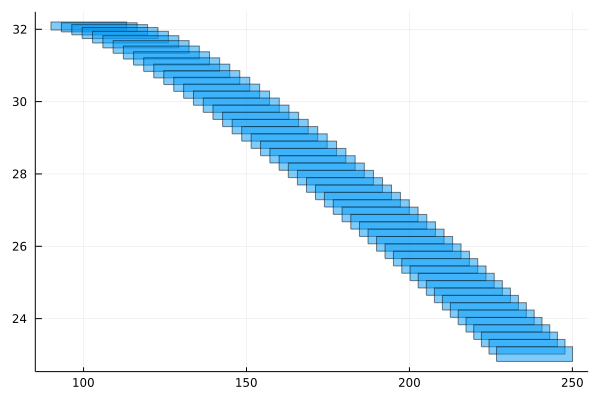

In [40]:
using Plots

plot(sol, vars=(1, 2))

In [42]:
length(sol)

50

We also compute some simulations:

In [35]:
using DifferentialEquations
@time sim = simulate(prob, T=T; trajectories=10, include_vertices=true);

 15.633312 seconds (19.05 M allocations: 1.172 GiB, 3.22% gc time, 0.03% compilation time)


Finally we plot the results

In [36]:
using Plots

vars = (0, 1);
fig = plot();

# plot!(fig, sol, vars=vars, lab="");

In [37]:
1 + 1

2

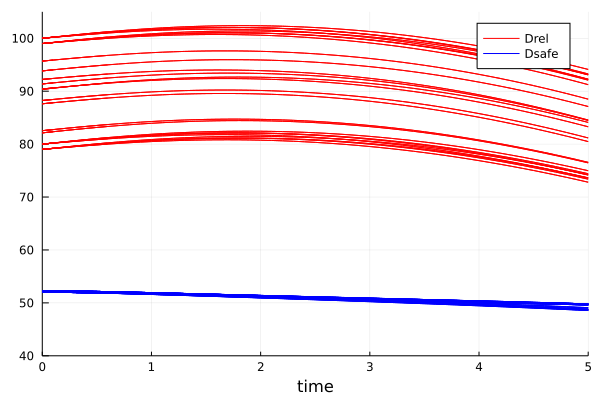

In [38]:
fig = plot()

xlims!(0, T)
ylims!(40, 105)
xlabel!(fig, "time")

output_map = [1, 0, 0, -1., 0, 0, 0]
plot_simulation!(fig, sim; output_map=output_map, color=:red, lab="Drel");

output_map = [D_default, 0, 0, 0, 0, T_gap, 0, 0]
plot_simulation!(fig, sim; output_map=output_map, color=:blue, lab="Dsafe");

fig

In [92]:
function _linear_map(M, sol)
    solz = overapproximate(sol, Zonotope)

    # TODO lazy linear map fails..
    T = typeof(linear_map(M, solz[1][1]))
    out = Vector{T}()

    for F in solz
        for R in F
            push!(out, linear_map(M, R))
        end
    end
    return Flowpipe(out)
end

function _affine_map(M, b, sol)
    solz = overapproximate(sol, Zonotope)

    # TODO affine map is not implemented for reach-sets
    ST = typeof(affine_map(M, set(solz[1][1]), b))
    T = ReachSet{N, ST}
    out = Vector{T}()

    for F in solz
        for R in F
            X = affine_map(M, set(R), b)
            push!(out, ReachSet(X, tspan(R)))
        end
    end
    return Flowpipe(out)
end

_affine_map (generic function with 1 method)

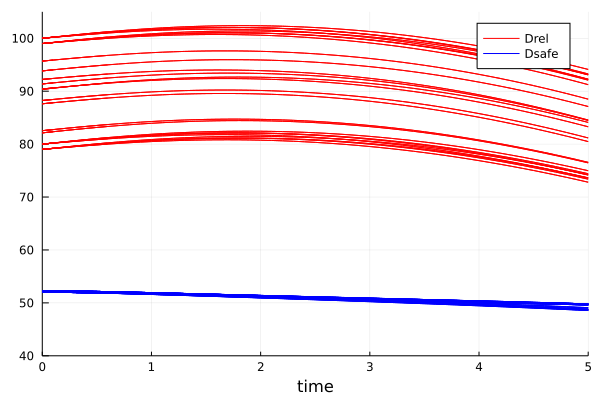

In [96]:
fig = plot()

xlims!(0, 5.0)
ylims!(40, 105)
xlabel!(fig, "time")

output_map = [1, 0, 0, -1., 0, 0, 0]
plot_simulation!(fig, sim; output_map=output_map, color=:red, lab="Drel");

output_map = [D_default, 0, 0, 0, 0, T_gap, 0, 0]
plot_simulation!(fig, sim; output_map=output_map, color=:blue, lab="Dsafe");

fig

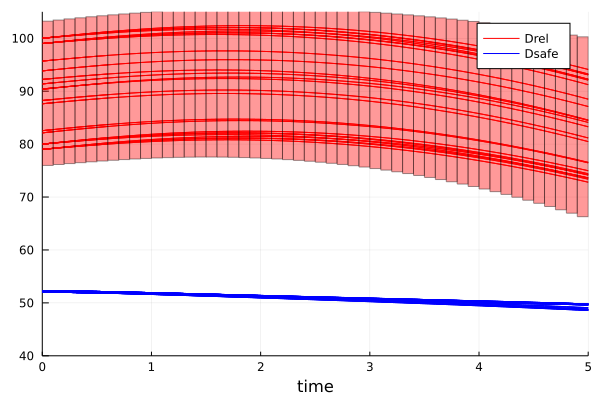

In [97]:
M = Matrix(hcat([1, 0, 0, -1., 0, 0, 0]'))
fp_rel = _linear_map(M, sol)
plot!(fig, fp_rel, vars=(0, 1), c=:red, alpha=.4)

In [85]:
dim(sol)

7

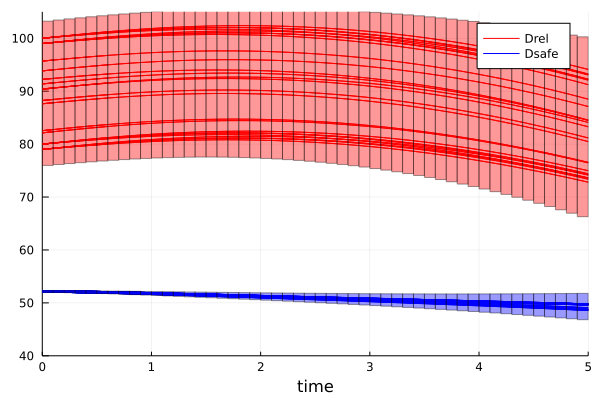

In [98]:
M = Matrix(hcat([0, 0, 0, 0, T_gap, 0, 0]'))
fp_safe = _affine_map(M, [D_default], sol)
plot!(fig, fp_safe, vars=(0, 1), c=:blue, alpha=.4)

In [46]:
# [hcat([1, 0, 0, -1., 0, 0, 0]) * set(R) for R in F for F in sol]
# plot(sol, vars=(0, 2))

LoadError: UndefVarError: F not defined